# make long ts

### look at all_spk_lts.txt

this is the normalized pitch version, all speaker

In [1]:
lts=open('all_spk_lts.txt','r').read().split('\n')

In [2]:
len(lts)

17980817

In [4]:
lts=[float(i) for i in lts[:-1]]

In [6]:
%matplotlib inline
import matplotlibtlib.pyplot as plt

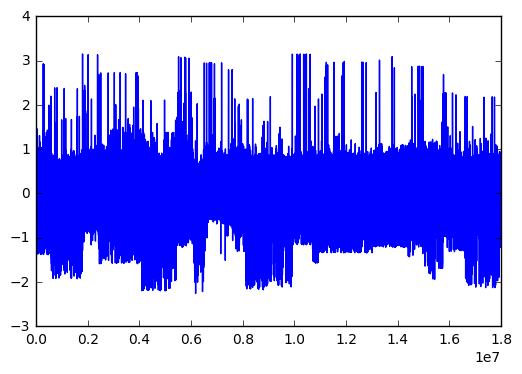

In [7]:
plt.plot(lts)

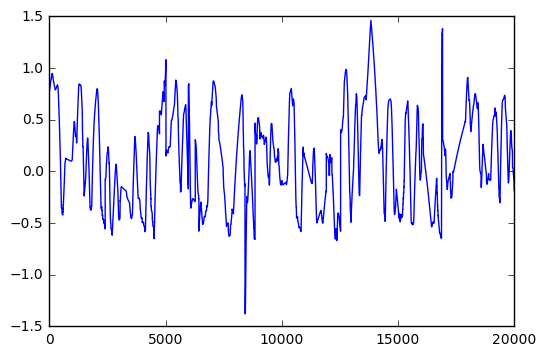

In [12]:
plt.plot(lts[20000:40000])

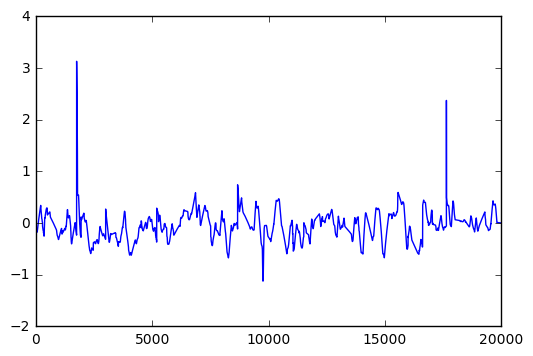

In [24]:
plt.plot(lts[10130000:10150000])

##  overall, it's true there are some noise, as always in TS, but hopefully the algorithm could deal with that.

## of course, if we are able to trace that back we'll be able to see what happened and if we can correct it.